In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Sat Feb 20 10:54:18 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Initialize Settings and import required packages

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pathname = "drive/MyDrive/Images"
print("[INFO] loading images...")
imagePaths = list(paths.list_images(pathname))
data = []
labels = []

[INFO] loading images...


## Import images with size of 224 x 224 and convert into numpy array

In [ ]:
for imagePath in imagePaths:
	# extract the class label from the filename
	label = imagePath.split(os.path.sep)[-2]

	# load the input image (224x224) and preprocess it
	image = load_img(imagePath, target_size=(224, 224))
	image = img_to_array(image)

	# update the data and labels lists, respectively
	data.append(image)
	labels.append(label)

# convert the data and labels to NumPy arrays
data = np.array(data, dtype="float32")
labels = np.array(labels)

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [ ]:
# perform one-hot encoding on the labels, keras/deep learning models require inputs to be in numbers.
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

## Split data into Train and Test sets

In [ ]:
# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
(trainX, testX, trainY, testY) = train_test_split(data, 
                                                  labels,
                                                  test_size=0.20,
                                                  stratify=labels,
                                                  random_state=421)

In [ ]:
print('Total number of images:',len(data))
print('Total number if images in training set:',len(trainX))
print('Total number of images in testing set:',len(testX))

Total number of images: 3588
Total number if images in training set: 2870
Total number of images in testing set: 718


## Split 10% of data in Train into Validation

In [ ]:
(trainX, validationX, trainY, validationY) = train_test_split(trainX, 
                                                  trainY,
                                                  test_size=0.1,
                                                  stratify=trainY,
                                                  random_state=421)

In [ ]:
print('Total number of images in validation set:',len(validationX))
print('Final number of images in training set:',len(trainX))

Total number of images in validation set: 287
Final number of images in training set: 2583


### Training data sample view

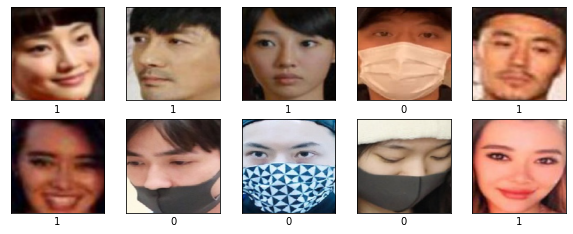

In [ ]:
%matplotlib inline
#Show first 10 training images below
plt.figure(figsize=(10,10))
for i in range(10):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow((trainX[i]).astype(np.uint8), cmap=plt.cm.binary)
    plt.xlabel(np.argmax(trainY[i]))

### Testing data sample view

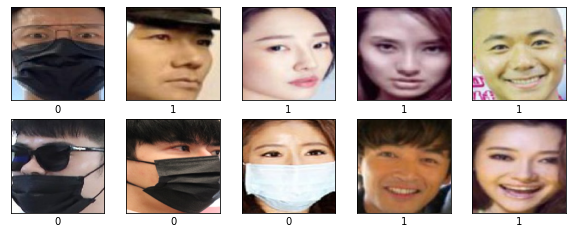

In [ ]:
%matplotlib inline
#Show first 10 training images below
plt.figure(figsize=(10,10))
for i in range(10):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow((testX[i]).astype(np.uint8), cmap=plt.cm.binary)
    plt.xlabel(np.argmax(testY[i]))

### Validation data sample view

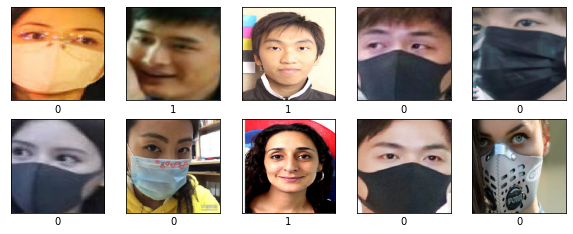

In [ ]:
%matplotlib inline
#Show first 10 training images below
plt.figure(figsize=(10,10))
for i in range(10):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow((validationX[i]).astype(np.uint8), cmap=plt.cm.binary)
    plt.xlabel(np.argmax(validationY[i]))

# Initialize data augmentation parameters

## Sample of how augmented data would look like

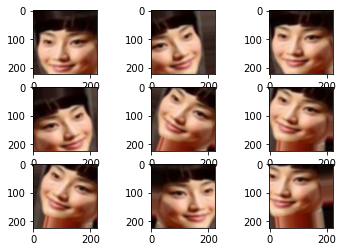

In [ ]:
datagen = ImageDataGenerator(
                             height_shift_range=0.2,
                             width_shift_range=0.2,
                             horizontal_flip=True,
                             rotation_range=20,
                             shear_range=0.15,
                             fill_mode='nearest')
# prepare iterator
it = datagen.flow(trainX[0:1], batch_size=1)
# generate samples and plot
for i in range(9):
	# define subplot
  plt.subplot(330 + 1 + i)
	# generate batch of images
  batch = it.next()
	# convert to unsigned integers for viewing
  image = batch[0].astype('uint8')
	# plot raw pixel data
  plt.imshow(image)
# show the figure
plt.show()

In [ ]:
train_augmentation = ImageDataGenerator(rescale = 1./255,
                                        rotation_range=20,
                                        width_shift_range=0.2,
                                        height_shift_range=0.2,
                                        shear_range=0.15,
                                        horizontal_flip=True,
                                        fill_mode="nearest")

validation_augmentation = ImageDataGenerator(rescale = 1./255)

In [ ]:
validation_scaled = validation_augmentation.flow(validationX,validationY)

# Build a CNN architecture from scratch

In [ ]:
INIT_LR = 0.001
EPOCHS = 100
BS = 32
adam_optimizer = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)

In [ ]:
input_shape = [224, 224, 3]
model = Sequential()
model.add(Conv2D(64, 3, activation='relu', input_shape=input_shape))
model.add(MaxPooling2D())
model.add(Conv2D(128, 3, activation='relu'))
model.add(MaxPooling2D())
#model.add(Conv2D(128, 3, activation='relu'))
#model.add(MaxPooling2D())
#model.add(Conv2D(256, 3, activation='relu'))
#model.add(GlobalAveragePooling2D())
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dense(2, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 128)     73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 373248)            0         
_________________________________________________________________
dropout (Dropout)            (None, 373248)            0         
_________________________________________________________________
dense (Dense)                (None, 64)                2

In [ ]:
model.output

<KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'dense_1')>

In [ ]:
model.compile(metrics=['accuracy'],
              optimizer=adam_optimizer,
              loss='binary_crossentropy')

## Fit the Model

In [ ]:
earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5,restore_best_weights=True)
classifier = model.fit(train_augmentation.flow(trainX, trainY, batch_size=BS),
                       steps_per_epoch=len(trainX) // BS,
                       validation_data=validation_scaled,
                       validation_steps = len(validationX) // BS,
                       epochs=EPOCHS, callbacks=[earlystop])

Epoch 1/100
80/80 [==============================] - 31s 344ms/step - loss: 1.2421 - accuracy: 0.6863 - val_loss: 0.2238 - val_accuracy: 0.9219
Epoch 2/100
80/80 [==============================] - 27s 338ms/step - loss: 0.2756 - accuracy: 0.9022 - val_loss: 0.1827 - val_accuracy: 0.9453
Epoch 3/100
80/80 [==============================] - 27s 337ms/step - loss: 0.3037 - accuracy: 0.8819 - val_loss: 0.1748 - val_accuracy: 0.9336
Epoch 4/100
80/80 [==============================] - 27s 338ms/step - loss: 0.2623 - accuracy: 0.9060 - val_loss: 0.1672 - val_accuracy: 0.9531
Epoch 5/100
80/80 [==============================] - 27s 337ms/step - loss: 0.2523 - accuracy: 0.9082 - val_loss: 0.1464 - val_accuracy: 0.9492
Epoch 6/100
80/80 [==============================] - 27s 338ms/step - loss: 0.2486 - accuracy: 0.9021 - val_loss: 0.1381 - val_accuracy: 0.9414
Epoch 7/100
80/80 [==============================] - 27s 337ms/step - loss: 0.2407 - accuracy: 0.9130 - val_loss: 0.1407 - val_accuracy:

## Visualize Accuracy and Loss Graphs

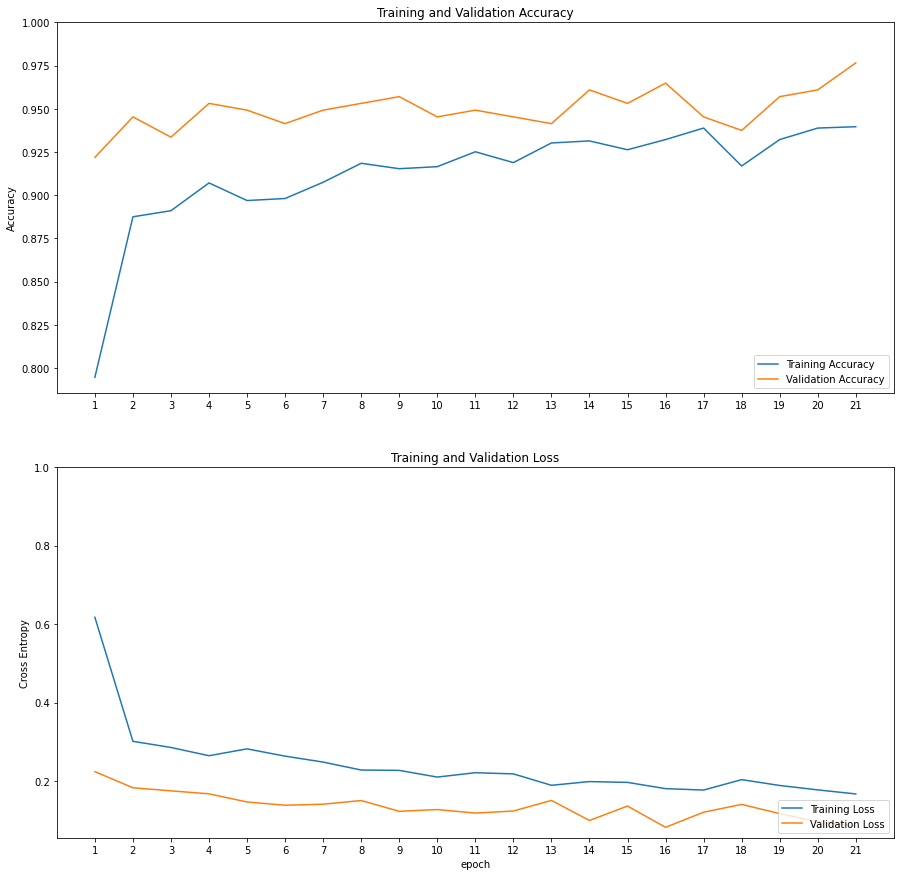

In [ ]:
acc = classifier.history['accuracy']
val_acc = classifier.history['val_accuracy']

loss = classifier.history['loss']
val_loss = classifier.history['val_loss']

plt.figure(figsize=(15,15))
plt.subplot(2,1,1)
plt.xticks(np.arange(len(acc)),np.arange(1,len(acc)+1))
plt.plot(acc, label ='Training Accuracy')
plt.plot(val_acc, label ='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2,1,2)
plt.xticks(np.arange(len(loss)),np.arange(1,len(loss)+1))
plt.plot(loss, label ='Training Loss')
plt.plot(val_loss, label ='Validation Loss')
plt.legend(loc='lower right')
plt.ylabel('Cross Entropy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
max_val_acc = val_acc.index(max(val_acc))
print('Maximum validation accuracy is achieved at epoch no.',max_val_acc+1,'with an accuracy of',round(val_acc[max_val_acc],4))

min_val_loss = val_loss.index(min(val_loss))
print('Minimum validation loss value is achieved at epoch no.',min_val_loss+1,'with a loss of',round(val_loss[min_val_loss],4))


Maximum validation accuracy is achieved at epoch no. 21 with an accuracy of 0.9766
Minimum validation loss value is achieved at epoch no. 16 with a loss of 0.0819


## Test model accuracy on test data

In [ ]:
test_loss, test_acc = model.evaluate(testX,testY)

23/23 [==============================] - 1s 31ms/step - loss: 20.7937 - accuracy: 0.9457


## Classification Report

In [ ]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

[INFO] evaluating network...
              precision    recall  f1-score   support

   with_mask       0.95      0.94      0.95       359
without_mask       0.94      0.95      0.95       359

    accuracy                           0.95       718
   macro avg       0.95      0.95      0.95       718
weighted avg       0.95      0.95      0.95       718



In [ ]:
model.save('/content/drive/MyDrive/Sweehong/mask_classification_model.h5', save_format="h5")

# Object Detection Model

In [ ]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
from google.colab.patches import cv2_imshow
import numpy as np
import cv2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## load resnet face detection ssd model

In [ ]:
prototxtPath = "/content/drive/MyDrive/Sweehong/deploy.prototxt"
weightsPath = "/content/drive/MyDrive/Sweehong/res10_300x300_ssd_iter_140000.caffemodel"
net = cv2.dnn.readNet(prototxtPath, weightsPath)

## load custom CNN model

In [ ]:
model = load_model('/content/drive/MyDrive/Sweehong/mask_classification_model.h5')

## Load images

In [ ]:
#image = cv2.imread('/content/drive/MyDrive/Testing Images/maksssksksss704.png')
image = cv2.imread('/content/drive/MyDrive/class2.jpg')
orig = image.copy()
(h, w) = image.shape[:2]

In [ ]:
# construct a blob from the image
blob = cv2.dnn.blobFromImage(image, 1.0, (1280, 960),
	(104.0, 177.0, 123.0))
net.setInput(blob)
detections = net.forward()

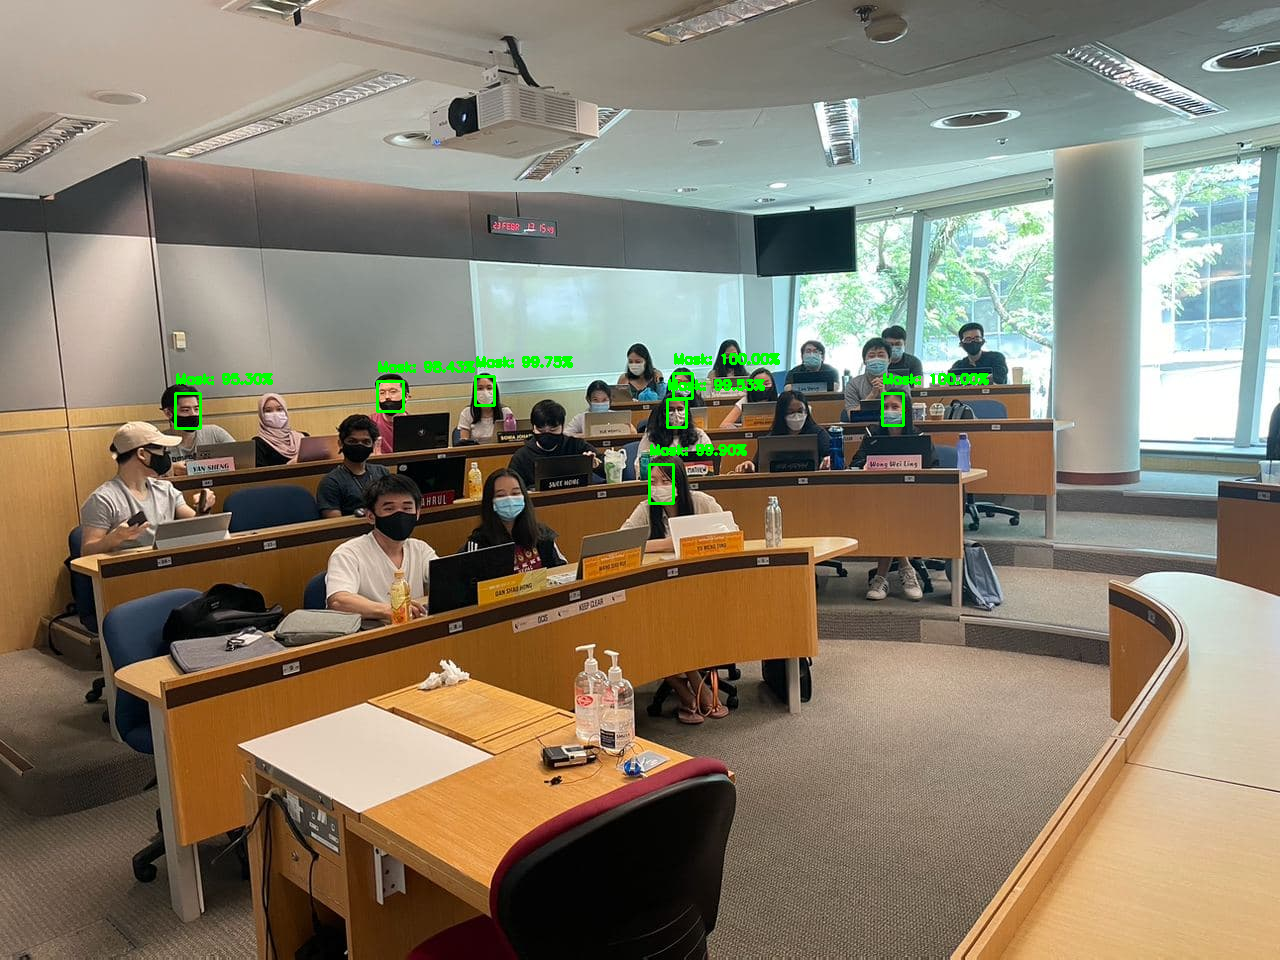

-1

In [ ]:
# loop over the detections
for i in range(0, detections.shape[2]):
  # extract the confidence (i.e., probability) associated with
  # the detection
  confidence = detections[0, 0, i, 2]
  # filter out weak detections by ensuring the confidence is
  # greater than the minimum confidence
  if confidence > 0.5:
    # compute the (x, y)-coordinates of the bounding box for
    # the object
    box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
    (startX, startY, endX, endY) = box.astype("int")
		# ensure the bounding boxes fall within the dimensions of
		# the frame
    (startX, startY) = (max(0, startX), max(0, startY))
    (endX, endY) = (min(w - 1, endX), min(h - 1, endY))
    face = image[startY:endY, startX:endX]
    face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
    face = cv2.resize(face, (224, 224))
    face = img_to_array(face)
    face = face/255
    face = np.expand_dims(face, axis=0)
    (mask, withoutMask) = model.predict(face)[0]
    # determine the class label and color we'll use to draw
    # the bounding box and text
    label = "Mask" if mask > withoutMask else "No Mask"
    color = (0, 255, 0) if label == "Mask" else (0, 0, 255)
    # include the probability in the label
    label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)
    # display the label and bounding box rectangle on the output
    # frame
    cv2.putText(image, label, (startX, startY - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
    cv2.rectangle(image, (startX, startY), (endX, endY), color, 2)
# show the output image
cv2_imshow(image)
cv2.waitKey(0)